In [1]:
%tensorflow_version 1.x
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pprint
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
import nst_utils

TensorFlow 1.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from nst_utils import *

In [3]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model(r"/content/drive/MyDrive/Colab Notebooks/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)


{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256)

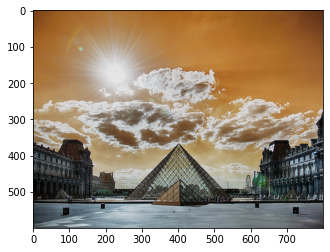

In [4]:
import cv2
image = cv2.imread("/content/sample_data/images/louvre.jpg")
plt.imshow(image)
plt.show()

In [5]:
import math
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.shape
    new_shape = [int(m), int(n_H * n_W), int(n_C)]
    a_C_unrolled = tf.reshape(a_C, new_shape)
    a_G_unrolled = tf.reshape(a_G, new_shape)
    temp = a_G_unrolled - a_C_unrolled
    J_content = (.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(tf.math.pow(temp,2))
    return J_content

In [6]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


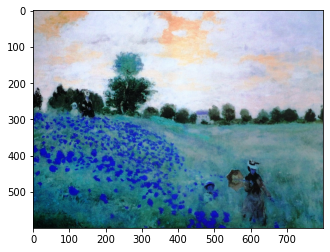

In [7]:
style_image = cv2.imread("/content/sample_data/images/monet_800600.jpg")
imshow(style_image);

In [8]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [9]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    print("GA = \n" + str(GA.eval()))

GA = 
[[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [10]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    factor = (.5 / (n_H * n_W * n_C)) ** 2
    J_style_layer = factor * tf.reduce_sum(tf.math.pow(GS - GG, 2))
    return J_style_layer

In [11]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [12]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [15]:
tf.reset_default_graph()
with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [16]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [17]:
content_image = cv2.imread("/content/sample_data/images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [18]:
style_image = cv2.imread("/content/sample_data/images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


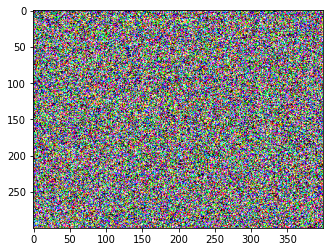

In [19]:
generated_image = generate_noise_image(content_image,1)
imshow(generated_image[0])

In [20]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model(r"/content/drive/MyDrive/Colab Notebooks/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

In [21]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [23]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        somthing = sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)
    save_image('output/generated_image.jpg', generated_image)
    return generated_image

In [25]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 9870724000.0
content cost = 14442.693
style cost = 246764500.0
Iteration 20 :
total cost = 2856726500.0
content cost = 21804.912
style cost = 71412710.0
Iteration 40 :
total cost = 1459386400.0
content cost = 23954.201
style cost = 36478670.0
Iteration 60 :
total cost = 865980000.0
content cost = 24683.637
style cost = 21643330.0
Iteration 80 :
total cost = 627054000.0
content cost = 25026.238
style cost = 15670095.0
Iteration 100 :
total cost = 504023100.0
content cost = 25397.736
style cost = 12594228.0
Iteration 120 :
total cost = 423090270.0
content cost = 25733.006
style cost = 10570823.0
Iteration 140 :
total cost = 363838660.0
content cost = 25965.918
style cost = 9089475.0
Iteration 160 :
total cost = 317333600.0
content cost = 26128.016
style cost = 7926808.0
Iteration 180 :
total cost = 279545920.0
content cost = 26253.703
style cost = 6982084.5


array([[[[ -34.285305 ,   -7.833004 ,   68.363754 ],
         [ -65.680916 ,  -29.06763  ,   73.432846 ],
         [ -75.62983  ,  -12.984587 ,   30.247143 ],
         ...,
         [  17.180048 ,   56.03095  ,  218.30344  ],
         [  51.650585 ,  139.72896  ,  123.85376  ],
         [  39.85852  ,   85.04666  ,   79.903946 ]],

        [[-129.89491  ,  -56.09501  ,  -62.905838 ],
         [ -75.63109  ,  -23.472101 ,  -33.84021  ],
         [ -29.372692 ,   -9.056584 ,  102.46705  ],
         ...,
         [ -28.170048 ,   28.097343 ,  176.74268  ],
         [ -10.313426 ,   13.692436 ,  101.16244  ],
         [ -37.290237 ,   58.95251  ,  105.8772   ]],

        [[-108.49041  ,  -54.064407 ,  -34.642254 ],
         [ -63.787212 ,  -32.686474 ,   20.857504 ],
         [ -16.788433 ,    9.933546 ,   66.59906  ],
         ...,
         [ -11.729717 ,  -33.190926 ,  159.25479  ],
         [ -13.417682 ,  -27.467758 ,  106.18959  ],
         [ -18.330555 ,  -21.232517 ,   81.94474  ]],